In [46]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [47]:
df = pd.read_csv("House_Rent_Dataset.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [48]:
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [49]:
df.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [50]:
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()
print("\n Числові:", num_features)
print("Категоріальні:", cat_features)


 Числові: ['BHK', 'Rent', 'Size', 'Bathroom']
Категоріальні: ['Posted On', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


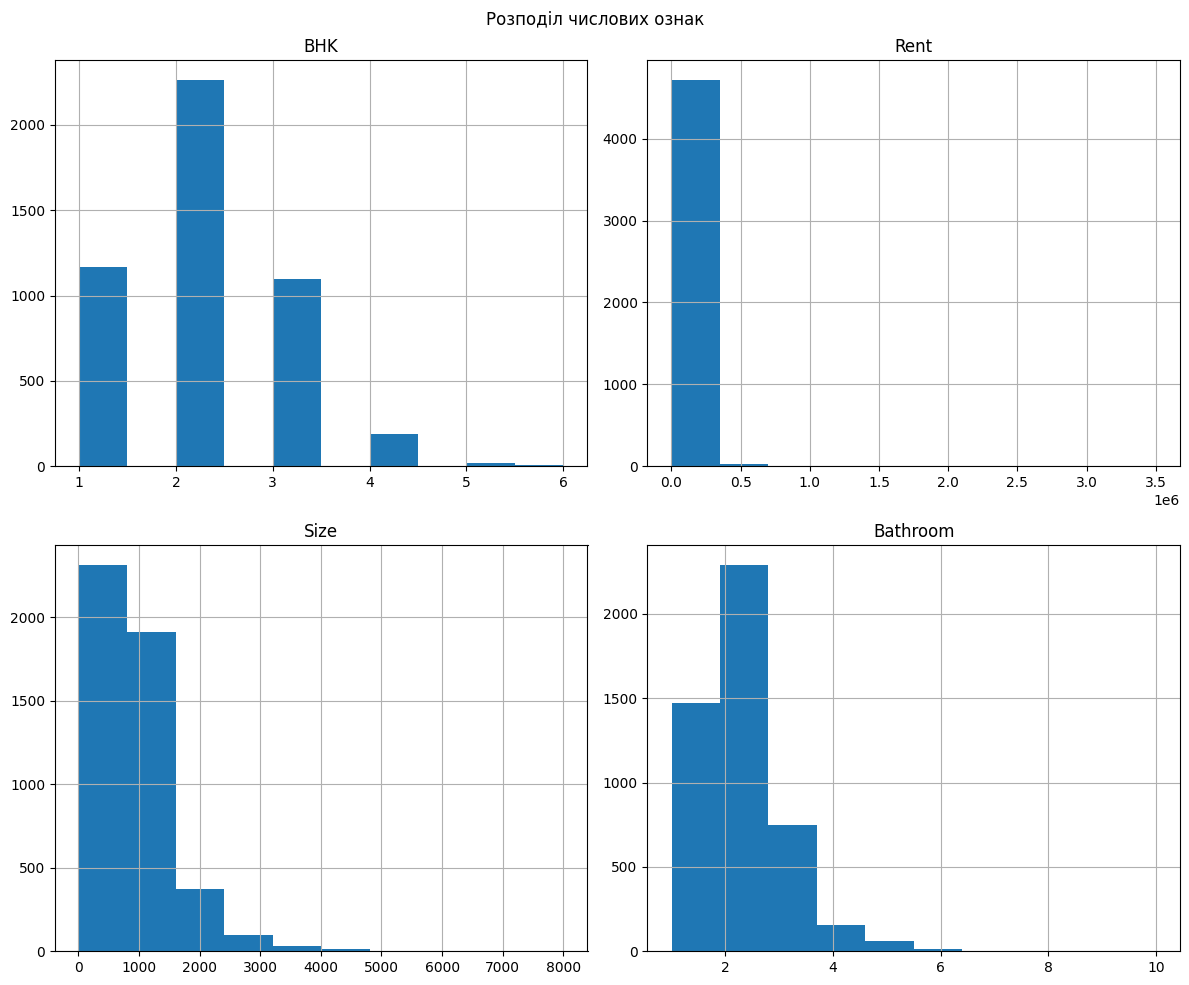

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns


df[num_features].hist(figsize=(12, 10), bins=10)
plt.suptitle("Розподіл числових ознак")
plt.tight_layout()
plt.show()

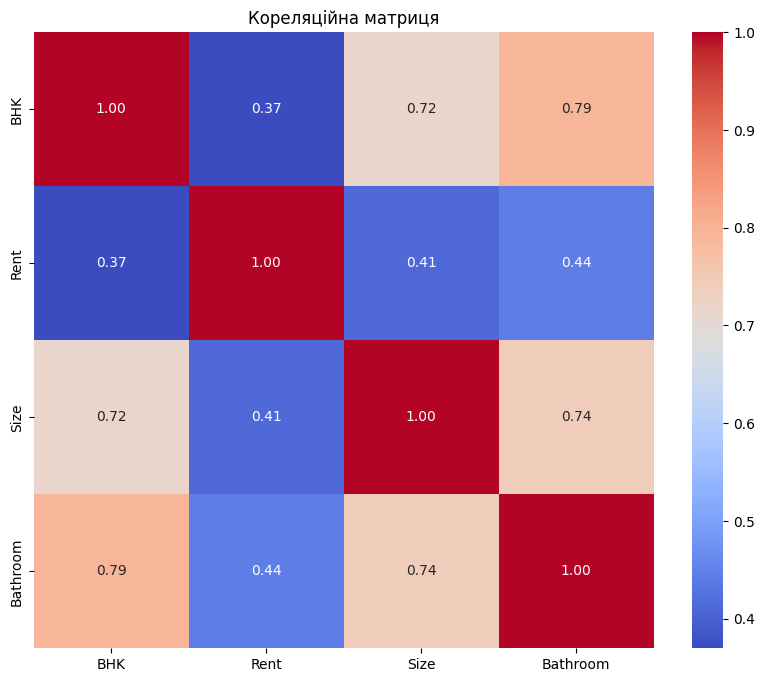

In [52]:
corr = df[num_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Кореляційна матриця")
plt.show()

In [53]:
def parse_floor(x):
    try:
        parts = x.split(" out of ")
        current = parts[0].replace("Ground", "0")
        total = parts[1]
        return int(current), int(total)
    except:
        return np.nan, np.nan

df["Floor_Current"], df["Floor_Total"] = zip(*df["Floor"].apply(parse_floor))

In [54]:
binary_features = [col for col in df.columns
                   if df[col].dtype == "object" and df[col].nunique() == 2]

for col in binary_features:
    vals = list(df[col].dropna().unique())
    df[col] = df[col].map({vals[0]: 0, vals[1]: 1})

In [55]:
df = df.drop(columns=["Posted On", "Floor"])

In [56]:
y = np.log1p(df["Rent"])
X = df.drop(columns=["Rent"])

In [57]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Числові ознаки:", numeric_features)
print("Категоріальні ознаки:", categorical_features)

Числові ознаки: ['BHK', 'Size', 'Bathroom', 'Floor_Current', 'Floor_Total']
Категоріальні ознаки: ['Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


In [58]:
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [59]:
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", num_transformer, numeric_features),
    ("cat", cat_transformer, categorical_features)
])

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [61]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42)
}


In [62]:
results = {}


for name, model in models.items():
    print(f"\n===== {name} =====")
    
    pipeline = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"MAE  = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")

    results[name] = {
        "preds": preds,
        "MAE": mae,
        "RMSE": rmse
    }



===== Linear Regression =====
MAE  = 0.42
RMSE = 0.57

===== Random Forest =====
MAE  = 0.27
RMSE = 0.36


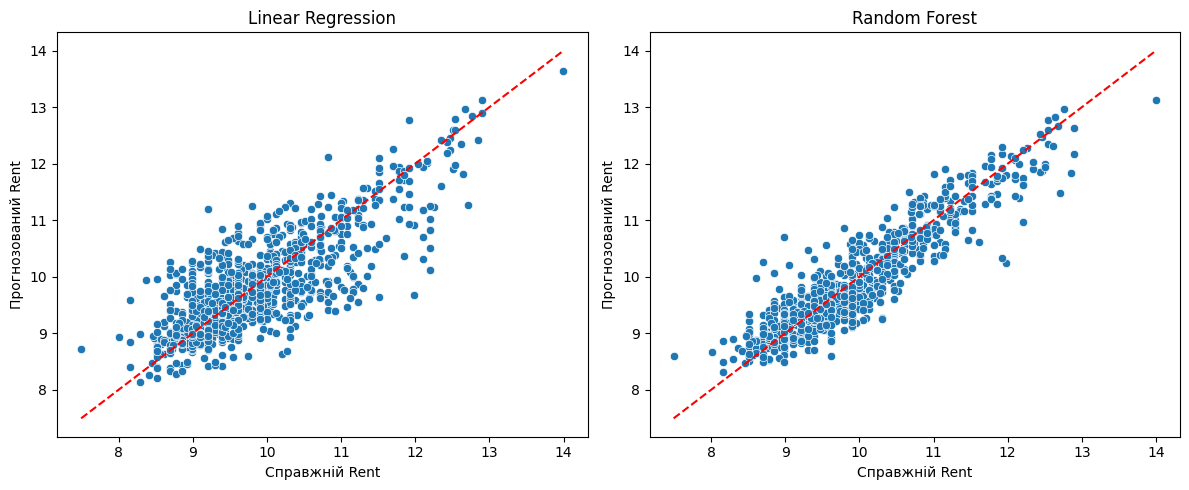

In [63]:
plt.figure(figsize=(12, 5))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(1, 2, i)
    sns.scatterplot(x=y_test, y=res["preds"])
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Справжній Rent")
    plt.ylabel("Прогнозований Rent")
    plt.title(name)
plt.tight_layout()
plt.show()

In [ ]:
for name, res in results.items():
    errors = np.abs(y_test - res["preds"])
    top_errors = errors.sort_values(ascending=False).head(5)
    print(f"\n===== {name} – топ 5 найбільших помилок =====")
    for i in top_errors.index: 
        true_val = y_test.loc[i] 
        pred_val = res["preds"][y_test.index.get_loc(i)]
        err_val = errors.loc[i]
        print(f"Індекс {i}: Справжнє={true_val}, Прогноз={pred_val:.2f}, Помилка={err_val:.2f}")



===== Linear Regression – топ 5 найбільших помилок =====
Індекс 530: Справжнє=11.982935344196433, Прогноз=9.67, Помилка=2.31
Індекс 2577: Справжнє=12.206077645517674, Прогноз=10.11, Помилка=2.10
Індекс 2086: Справжнє=9.210440366976517, Прогноз=11.20, Помилка=1.99
Індекс 977: Справжнє=11.51293546492023, Прогноз=9.65, Помилка=1.86
Індекс 1161: Справжнє=12.100717685412471, Прогноз=10.31, Помилка=1.79

===== Random Forest – топ 5 найбільших помилок =====
Індекс 530: Справжнє=11.982935344196433, Прогноз=10.25, Помилка=1.73
Індекс 2630: Справжнє=8.987321812850125, Прогноз=10.70, Помилка=1.71
Індекс 2598: Справжнє=11.918397239722838, Прогноз=10.34, Помилка=1.58
Індекс 1270: Справжнє=8.699681400989514, Прогноз=10.27, Помилка=1.57
Індекс 944: Справжнє=8.612685172875459, Прогноз=9.99, Помилка=1.37


In [65]:
summary = pd.DataFrame({
    "Model": list(results.keys()),
    "MAE": [results[m]["MAE"] for m in results],
    "RMSE": [results[m]["RMSE"] for m in results]
})
print("\n===== Порівняння моделей =====")
print(summary)


===== Порівняння моделей =====
               Model       MAE      RMSE
0  Linear Regression  0.415153  0.567002
1      Random Forest  0.268530  0.359689
